<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/modelling/am_topic_modelling_analysis_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective: Automated Financial Topic Modeling & Sentiment Analysis**
The primary objective of this code is to extract, analyze, and categorize financial discussions from quarterly reports and management discussions using multiple NLP-based topic modeling approaches. The code aims to identify key themes and track topic trends over time while also incorporating sentiment analysis to assess the tone of discussions.

To achieve this, the code integrates a variety of topic modeling techniques, including probabilistic, clustering-based, and transformer-based approaches, ensuring a comprehensive and comparative analysis of financial text.

# **Key Approaches**
LDA (Latent Dirichlet Allocation)

BERTopic (HDBSCAN)

BERTopic + FinBERT

Falcon models both LLM and light instruct model (Failed as notebook crashed. Thus excluded)

GPT model - GPT-4-Turbo

# **Section 1: Libraries & Package installation**

In [1]:
!pip install -q bertopic > /dev/null 2>&1
!pip install -q umap-learn > /dev/null 2>&1
!pip install -q hdbscan > /dev/null 2>&1
!pip install -q sentence-transformers > /dev/null 2>&1
!pip install -q bertopic sentence-transformers gensim scikit-learn transformers nltk > /dev/null 2>&1
!pip install -q pyLDAvis > /dev/null 2>&1
!pip install -q python-dotenv > /dev/null 2>&1

In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from transformers import pipeline
import nltk
from nltk.tokenize import word_tokenize
import string
import os

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic
from hdbscan import HDBSCAN
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from sklearn.cluster import KMeans
import string
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.tokenize import sent_tokenize
import json
import time
import os
import sys
from google.colab import drive

In [4]:
# Download NLTK resources (run these lines once)
nltk.download('punkt')
nltk.download('stopwords')
# Download the punkt_tab data package
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:

# Mount Google Drive to the root location
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [6]:
input_df = pd.read_csv("/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/Topic_Modelling_am/tqc_JPMorgan_answer_topic.csv")

In [7]:
# Copy the first 5 rows of input_df
input_df = input_df.head(5).copy()

# **Section 2: Topic Modelling: Data --> LDA**

In [ ]:
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from itertools import combinations
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
import string

nltk.download('punkt')
nltk.download('stopwords')

# Load DataFrame
df = input_df.copy()  # Your dataframe
df = df.dropna(subset=['Response_cleaned'])  # Drop NaNs

# ==============================
# 1. TEXT PREPROCESSING
# ==============================
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text.lower())  # Tokenization & lowercase
    words = [w for w in words if w not in stop_words and w not in string.punctuation]  # Remove stopwords & punctuation
    return words

df['processed_text'] = df['Response_cleaned'].apply(preprocess_text)

# ==============================
# 2. LDA TOPIC MODELING
# ==============================
# Create Dictionary and Corpus
dictionary = corpora.Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

# Train LDA Model
num_topics = 5  # Adjust based on your data
lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Extract Topics
topics = lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False)
topics_dict = {i: [word[0] for word in topic[1]] for i, topic in enumerate(topics)}

print("\n=== LDA Topics ===")
for topic_id, words in topics_dict.items():
    print(f"Topic {topic_id}: {', '.join(words)}")

# ==============================
# 3. TOPIC COHERENCE
# ==============================
coherence_model = CoherenceModel(model=lda_model, texts=df['processed_text'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nTopic Coherence (C_V): {coherence_score:.4f}")

# ==============================
# 4. TOPIC DIVERSITY (Jaccard Similarity)
# ==============================
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

topic_word_sets = [set(words) for words in topics_dict.values()]
jaccard_scores = [jaccard_similarity(a, b) for a, b in combinations(topic_word_sets, 2)]
avg_jaccard = np.mean(jaccard_scores)

print(f"Topic Diversity (Avg Jaccard Similarity): {avg_jaccard:.4f}")

# ==============================
# 5. SENTIMENT CONSISTENCY (FinBERT)
# ==============================
finbert_sentiment = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

def get_topic_sentiments(topics, df):
    topic_sentiments = defaultdict(list)

    for topic_id, words in topics.items():
        relevant_texts = df[df['processed_text'].apply(lambda x: any(word in x for word in words))]['Response_cleaned']

        if len(relevant_texts) > 0:
            sentiments = [finbert_sentiment(text[:512])[0]['label'] for text in relevant_texts]  # Limit text length
            topic_sentiments[topic_id] = sentiments

    return topic_sentiments

topic_sentiments = get_topic_sentiments(topics_dict, df)

print("\n=== Sentiment Analysis per Topic ===")
for topic_id, sentiments in topic_sentiments.items():
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True).to_dict()
    print(f"Topic {topic_id}: {sentiment_counts}")

# ==============================
# 6. SIMILARITY TO PREDEFINED TOPICS (TF-IDF & Cosine Similarity)
# ==============================
predefined_topics = [
    "revenue growth profitability",
    "regulatory compliance risk",
    "operational costs efficiency",
    "customer satisfaction service",
    "market expansion strategy"
]

extracted_topic_words = [" ".join(words) for words in topics_dict.values()]
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(extracted_topic_words + predefined_topics)
similarity_matrix = cosine_similarity(topic_vectors[:len(extracted_topic_words)], topic_vectors[len(extracted_topic_words):])

avg_similarity = similarity_matrix.mean()
print(f"\nTopic Similarity to Predefined Topics (Cosine): {avg_similarity:.4f}")

# ==============================
# 7. TOPIC STABILITY (Splitting Data)
# ==============================
df_shuffled = df.sample(frac=1, random_state=42)  # Shuffle dataset
df_part1 = df_shuffled.iloc[:len(df)//2]
df_part2 = df_shuffled.iloc[len(df)//2:]

corpus_part1 = [dictionary.doc2bow(text) for text in df_part1['processed_text']]
corpus_part2 = [dictionary.doc2bow(text) for text in df_part2['processed_text']]

lda_part1 = gensim.models.LdaModel(corpus=corpus_part1, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
lda_part2 = gensim.models.LdaModel(corpus=corpus_part2, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

topics_part1 = {i: [word[0] for word in topic[1]] for i, topic in enumerate(lda_part1.show_topics(num_topics=num_topics, num_words=10, formatted=False))}
topics_part2 = {i: [word[0] for word in topic[1]] for i, topic in enumerate(lda_part2.show_topics(num_topics=num_topics, num_words=10, formatted=False))}

# Compute Jaccard Similarity Between Two Runs
stability_scores = [jaccard_similarity(set(topics_part1[i]), set(topics_part2[i])) for i in range(num_topics)]
avg_stability = np.mean(stability_scores)

print(f"\nTopic Stability (Jaccard Between Two Runs): {avg_stability:.4f}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== LDA Topics ===
Topic 0: company, lot, focus, current, efficiency, growth, thats, also, means, good
Topic 1: growth, means, company, think, focus, efficiency, always, areas, well, bit
Topic 2: company, growth, efficiency, bit, lot, would, current, focus, thats, means
Topic 3: efficiency, company, growth, think, focus, current, means, would, always, good
Topic 4: efficiency, growth, current, think, well, means, good, bit, company, lot

Topic Coherence (C_V): 0.2383
Topic Diversity (Avg Jaccard Similarity): 0.5198


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



=== Sentiment Analysis per Topic ===
Topic 0: {'Positive': 1.0}
Topic 1: {'Positive': 1.0}
Topic 2: {'Positive': 1.0}
Topic 3: {'Positive': 1.0}
Topic 4: {'Positive': 1.0}

Topic Similarity to Predefined Topics (Cosine): 0.0346

Topic Stability (Jaccard Between Two Runs): 1.0000


# **Section 3: Topic Modelling: Data --> BERTopic**

In [8]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from itertools import combinations
import numpy as np
from transformers import pipeline
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [9]:
nltk.download('punkt')
nltk.download('stopwords')

# Load DataFrame
df = input_df.copy()
df = df.dropna(subset=['Response_cleaned'])  # Drop NaNs

# ==============================
# 1. TEXT PREPROCESSING
# ==============================
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text.lower())  # Tokenization & lowercase
    words = [w for w in words if w not in stop_words and w not in string.punctuation]  # Remove stopwords & punctuation
    return " ".join(words)

df['processed_text'] = df['Response_cleaned'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
df

,Quarter,Question,Question_cleaned,Analyst,Analyst Role,Response,Response_cleaned,Executive,Executive Role Type,Topic,Snippet,processed_text
0,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Capital Deployment Strategy,noted points always make repeat them think way...,'yeah good question john welcome back way yeah...
1,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Strategic Financial Decisions,feels like correct kind strategic financial de...,'yeah good question john welcome back way yeah...
2,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Organic Capital Generation and Return,given amount organic capital generation produc...,'yeah good question john welcome back way yeah...
3,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Investment Focus and Company Culture,in terms high certainty investment choices acr...,'yeah good question john welcome back way yeah...
4,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO,Technology and Efficiency,starters putting lot effort improving sort abi...,'yeah good question john welcome back way yeah...


In [11]:
from bertopic import BERTopic
import textwrap

# Merge all processed text into one large document
merged_text = " ".join(df['processed_text'].tolist())

# Split the large text into smaller chunks (e.g., ~50 words per pseudo-document)
chunk_size = 50  # Adjust as needed
pseudo_documents = textwrap.wrap(merged_text, width=chunk_size)

print(f"Total pseudo-documents created: {len(pseudo_documents)}")

Total pseudo-documents created: 325


In [12]:
# Run BERTopic on these pseudo-documents
topic_model = BERTopic(language="english", calculate_probabilities=True)
topics, probs = topic_model.fit_transform(pseudo_documents)

# Get and print topic information
topic_info = topic_model.get_topic_info()
print("\n=== Extracted Topics ===")
print(topic_info)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


=== Extracted Topics ===
    Topic  Count                                       Name  \
0      -1     25              -1_risk_aggregate_six_running   
1       0     80        0_efficiency_organic_focus_embedded   
2       1     35           1_kind_certainty_high_investment   
3       2     30  2_margin_trajectory_opportunities_company   
4       3     25                3_always_peak_yeah_thinking   
5       4     25     4_consistent_themes_categories_broadly   
6       5     25                  5_excess_enough_given_bit   
7       6     20         6_current_better_extra_essentially   
8       7     15         7_putting_ways_improving_iterating   
9       8     15    8_focus_consider_efficiencies_engineers   
10      9     15                  9_count_head_flat_finally   
11     10     15            10_headcount_growth_year_budget   

                                       Representation  \
0   [risk, aggregate, six, running, reds, needs, m...   
1   [efficiency, organic, focus, embedde

In [14]:
# ==============================
# 3. TOPIC COHERENCE
# ==============================
texts = [text.split() for text in df['processed_text']] # Change df to df['processed_text']
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Get topics from the BERTopic model
topic_info_df = topic_model.get_topic_info()
topics_dict = {row['Topic']: row['Representation'] for _, row in topic_info_df.iterrows() if row['Topic'] != -1} # Split the Representation string into a list of words

# Now calculate coherence with the updated topics_dict
coherence_model = CoherenceModel(topics=list(topics_dict.values()), texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nTopic Coherence (C_V): {coherence_score:.4f}")


Topic Coherence (C_V): 0.4427


In [15]:
# ==============================
# 4. TOPIC DIVERSITY (Jaccard Similarity)
# ==============================
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

topic_word_sets = [set(words) for words in topics_dict.values()]
jaccard_scores = [jaccard_similarity(a, b) for a, b in combinations(topic_word_sets, 2)]
avg_jaccard = np.mean(jaccard_scores)

print(f"Topic Diversity (Avg Jaccard Similarity): {avg_jaccard:.4f}")

Topic Diversity (Avg Jaccard Similarity): 0.0019


In [16]:
# df

In [17]:
# ==============================
# 5. SENTIMENT CONSISTENCY (FinBERT)
# ==============================
finbert_sentiment = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

def get_topic_sentiments(topics, df):
    topic_sentiments = {}

    for topic_id, words in topics.items():
        relevant_texts = df

        if len(relevant_texts) > 0:
            sentiments = [finbert_sentiment(text[:512])[0]['label'] for text in relevant_texts]  # Limit text length
            topic_sentiments[topic_id] = sentiments

    return topic_sentiments

#topic_sentiments = get_topic_sentiments(topics_dict, df)
# After Correction
topic_sentiments = get_topic_sentiments(topics_dict, input_df)

print("\n=== Sentiment Analysis per Topic ===")
for topic_id, sentiments in topic_sentiments.items():
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True).to_dict()
    print(f"Topic {topic_id}: {sentiment_counts}")

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



=== Sentiment Analysis per Topic ===
Topic 0: {'Neutral': 1.0}
Topic 1: {'Neutral': 1.0}
Topic 2: {'Neutral': 1.0}
Topic 3: {'Neutral': 1.0}
Topic 4: {'Neutral': 1.0}
Topic 5: {'Neutral': 1.0}
Topic 6: {'Neutral': 1.0}
Topic 7: {'Neutral': 1.0}
Topic 8: {'Neutral': 1.0}
Topic 9: {'Neutral': 1.0}
Topic 10: {'Neutral': 1.0}


In [18]:
# ==============================
# 6. SIMILARITY TO PREDEFINED TOPICS (TF-IDF & Cosine Similarity)
# ==============================
predefined_topics = [
    "revenue growth profitability",
    "regulatory compliance risk",
    "operational costs efficiency",
    "market expansion strategy"
]

extracted_topic_words = [" ".join(words) for words in topics_dict.values()]
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(extracted_topic_words + predefined_topics)
similarity_matrix = cosine_similarity(topic_vectors[:len(extracted_topic_words)], topic_vectors[len(extracted_topic_words):])

avg_similarity = similarity_matrix.mean()
print(f"\nTopic Similarity to Predefined Topics (Cosine): {avg_similarity:.4f}")


Topic Similarity to Predefined Topics (Cosine): 0.0088


In [19]:
df=input_df.copy()

In [20]:
# ==============================
# 7. TOPIC STABILITY (Splitting Data)
# ==============================
df_shuffled = df.sample(frac=1, random_state=42)  # Shuffle dataset
df_part1 = df_shuffled.iloc[:len(df)//2]
df_part2 = df_shuffled.iloc[len(df)//2:]

topic_model_part1 = BERTopic(language="english", calculate_probabilities=True)
topics_part1, _ = topic_model_part1.fit_transform(pseudo_documents)
# topics_part1 is already a list, no need to convert
#topics_part1 = topics_part1.tolist()

topic_model_part2 = BERTopic(language="english", calculate_probabilities=True)
topics_part2, _ = topic_model_part2.fit_transform(pseudo_documents)

topic_info_part1 = topic_model_part1.get_topic_info()
topic_info_part2 = topic_model_part2.get_topic_info()

#topics_dict_part1 = {row["Topic"]: row["Representation"].split() for _, row in topic_info_part1.iterrows() if row["Topic"] != -1}
#topics_dict_part2 = {row["Topic"]: row["Representation"].split() for _, row in topic_info_part2.iterrows() if row["Topic"] != -1}
topics_dict_part1 = {row['Topic']: row['Representation'] for _, row in topic_info_df.iterrows() if row['Topic'] != -1}
topics_dict_part2 = {row['Topic']: row['Representation'] for _, row in topic_info_df.iterrows() if row['Topic'] != -1}

# Compute Jaccard Similarity Between Two Runs
stability_scores = [jaccard_similarity(set(topics_dict_part1[i]), set(topics_dict_part2[i]))
                    for i in set(topics_dict_part1.keys()) & set(topics_dict_part2.keys())]

avg_stability = np.mean(stability_scores)
print(f"\nTopic Stability (Jaccard Between Two Runs): {avg_stability:.4f}")


Topic Stability (Jaccard Between Two Runs): 1.0000


# **Section 4: Topic Modelling data: --> FinBERT Embedding with BERTopic**

In [21]:
# Load Pseudo Documents
df = pseudo_documents.copy()

In [22]:
# ==============================
# 1️⃣ EMBEDDING USING FinBERT
# ==============================
print("Generating FinBERT embeddings...")
embedding_model = SentenceTransformer("ProsusAI/finbert")
embeddings = embedding_model.encode(df, show_progress_bar=True)

Generating FinBERT embeddings...


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

In [23]:
# ==============================
# 2️⃣ TRAIN BERTopic WITH FinBERT EMBEDDINGS
# ==============================
print("Running BERTopic with FinBERT embeddings...")
topic_model = BERTopic(language="english", calculate_probabilities=True)
topics, probs = topic_model.fit_transform(df, embeddings=embeddings)

# Extract topic words
topic_info = topic_model.get_topic_info()
topics_dict = {row["Topic"]: row["Representation"] for _, row in topic_info.iterrows() if row["Topic"] != -1} # Use topic_info which is a DataFrame

print("\n=== Extracted Topics ===")
for topic_id, words in topics_dict.items():
    print(f"Topic {topic_id}: {', '.join(words)}")

Running BERTopic with FinBERT embeddings...

=== Extracted Topics ===
Topic 0: areas, focus, always, fact, gotten, happens, says, give, want, main
Topic 1: organic, continue, current, efficiency, iterating, plan, said, product, producing, generate
Topic 2: say, thinking, know, well, would, truth, sure, terms, repeat, suggest
Topic 3: given, enough, else, equal, excess, would, otherwise, pockets, relative, return
Topic 4: headcount, going, means, growth, inefficiency, went, quantum, rate, roughly, still
Topic 5: consistent, themes, teams, efficiency, efficiencies, creative, hardware, remarkably, stuff, seeing
Topic 6: thats, yeah, bottomsup, case, noting, another, john, investor, safely, remains
Topic 7: opportunities, deployment, deploy, tweaked, chance, different, greens, near, pursue, term
Topic 8: contributed, choices, grown, years, modernization, jamie, reached, reasons, results, spend
Topic 9: enable, ensure, management, needs, obviously, strong, positions, running, significantly,

In [24]:
# ==============================
# 3️⃣ TOPIC COHERENCE (C_V)
# ==============================
print("Calculating topic coherence...")
texts = [word_tokenize(text.lower()) for text in df]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

coherence_model = CoherenceModel(topics=list(topics_dict.values()), texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nTopic Coherence (C_V): {coherence_score:.4f}")

Calculating topic coherence...

Topic Coherence (C_V): 0.3340


In [25]:
# ==============================
# 4️⃣ TOPIC DIVERSITY (Jaccard Similarity)
# ==============================
print("Calculating topic diversity...")
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

topic_word_sets = [set(words) for words in topics_dict.values()]
jaccard_scores = [jaccard_similarity(a, b) for a, b in combinations(topic_word_sets, 2)]
avg_jaccard = np.mean(jaccard_scores)

print(f"Topic Diversity (Avg Jaccard Similarity): {avg_jaccard:.4f}")

Calculating topic diversity...
Topic Diversity (Avg Jaccard Similarity): 0.0019


In [26]:
# ==============================
# 5️⃣ SENTIMENT CONSISTENCY (FinBERT Sentiment Analysis)
# ==============================
print("Running sentiment analysis on extracted topics...")
finbert_sentiment = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

def get_topic_sentiments(topics, df):
    topic_sentiments = {}

    for topic_id, words in topics.items():
        relevant_texts = df

        if len(relevant_texts) > 0:
            sentiments = [finbert_sentiment(text[:512])[0]['label'] for text in relevant_texts]  # Limit text length
            topic_sentiments[topic_id] = sentiments

    return topic_sentiments

topic_sentiments = get_topic_sentiments(topics_dict, df)

print("\n=== Sentiment Analysis per Topic ===")
for topic_id, sentiments in topic_sentiments.items():
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True).to_dict()
    print(f"Topic {topic_id}: {sentiment_counts}")

Running sentiment analysis on extracted topics...


Device set to use cuda:0



=== Sentiment Analysis per Topic ===
Topic 0: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 1: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 2: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 3: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 4: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 5: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 6: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 7: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}
Topic 8: {'Neutral': 0.6461538461538462, 'Positive': 0.27692307692307694, 'Negative': 0.07692307692307693}

In [27]:
# ==============================
# 6️⃣ SIMILARITY TO PREDEFINED FINANCIAL TOPICS (TF-IDF & Cosine Similarity)
# ==============================
print("Calculating similarity to predefined financial topics...")
predefined_topics = [
    "revenue growth profitability",
    "regulatory compliance risk",
    "operational costs efficiency",
    "market expansion strategy"
]

extracted_topic_words = [" ".join(words) for words in topics_dict.values()]
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(extracted_topic_words + predefined_topics)
similarity_matrix = cosine_similarity(topic_vectors[:len(extracted_topic_words)], topic_vectors[len(extracted_topic_words):])

avg_similarity = similarity_matrix.mean()
print(f"\nTopic Similarity to Predefined Financial Topics (Cosine): {avg_similarity:.4f}")

Calculating similarity to predefined financial topics...

Topic Similarity to Predefined Financial Topics (Cosine): 0.0088


In [30]:
# ==============================
# 7️⃣ TOPIC STABILITY (Splitting Data and Re-running BERTopic)
# ==============================
print("Checking topic stability across data splits...")
df_part1 = df_shuffled.iloc[:len(df)//2]
df_part2 = df_shuffled.iloc[len(df)//2:]

# Fix: Encoding pseudo-document text directly
embeddings_part1 = embedding_model.encode(df_part1['Response_cleaned'].tolist(), show_progress_bar=False)
embeddings_part2 = embedding_model.encode(df_part2['Response_cleaned'].tolist(), show_progress_bar=False)

#topic_model = BERTopic(language="english", calculate_probabilities=True, umap_model=UMAP(n_neighbors=10))  # Reduce n_neighbors

topic_model_part1 = BERTopic(language="english", calculate_probabilities=True)
topics_part1, _ = topic_model_part1.fit_transform(pseudo_documents)
# topics_part1 is already a list, no need to convert
#topics_part1 = topics_part1.tolist()

topic_model_part2 = BERTopic(language="english", calculate_probabilities=True)
topics_part2, _ = topic_model_part2.fit_transform(pseudo_documents)

#topic_model_part1 = BERTopic(language="english", calculate_probabilities=True, umap_model=UMAP(n_neighbors=10))
# Fix: Fitting pseudo-document text directly
#topics_part1, _ = topic_model_part1.fit_transform(df_part1['Response_cleaned'].tolist(), embeddings=embeddings_part1)

#topic_model_part2 = BERTopic(language="english", calculate_probabilities=True, umap_model=UMAP(n_neighbors=10))
# Fix: Fitting pseudo-document text directly
#topics_part2, _ = topic_model_part2.fit_transform(df_part2['Response_cleaned'].tolist(), embeddings=embeddings_part2)

topic_info_part1 = topic_model_part1.get_topic_info()
topic_info_part2 = topic_model_part2.get_topic_info()

topics_dict_part1 = {row["Topic"]: row["Representation"] for _, row in topic_info_part1.iterrows() if row["Topic"] != -1}
topics_dict_part2 = {row["Topic"]: row["Representation"] for _, row in topic_info_part2.iterrows() if row["Topic"] != -1}

# Compute Jaccard Similarity Between Two Runs
stability_scores = [jaccard_similarity(set(topics_dict_part1[i]), set(topics_dict_part2[i]))
                    for i in set(topics_dict_part1.keys()) & set(topics_dict_part2.keys())]

avg_stability = np.mean(stability_scores)
print(f"\nTopic Stability (Jaccard Between Two Runs): {avg_stability:.4f}")

Checking topic stability across data splits...

Topic Stability (Jaccard Between Two Runs): 0.2308


# **Sction 5: GPT based Modelling**

In [40]:
!pip install -q openai==0.28

In [41]:
import openai
import pandas as pd
import numpy as np
import time
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations
from transformers import pipeline
import nltk
from nltk.tokenize import word_tokenize
import string

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
input_df=pd.read_csv("/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/Topic_Modelling_am/tqc_JPMorgan_answer_topic.csv")

# Load Data
df = input_df.head(5).copy()
df = df.dropna(subset=['Response_cleaned'])  # Ensure no NaNs
df['text'] = df['Response_cleaned'].astype(str)

In [37]:
!pip install -q openai==0.28

In [54]:
import openai
import time

def extract_topic_gpt4(text):
    client = openai.OpenAI(api_key=openai.api_key)  # Create a client instance

    prompt = f"""
    Extract a concise topic label (max 5 words) and top 5 keywords for the following financial text:

    "{text}"

    Output format: Topic: <Topic Label>, Keywords: <keyword1>, <keyword2>, <keyword3>, <keyword4>, <keyword5>
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4-turbo",
            messages=[
                {"role": "system", "content": "You are an expert in financial NLP."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0
        )

        extracted_text = response.choices[0].message.content
        return extracted_text

    except Exception as e:
        print(f"Error extracting topic: {e}")
        return "Topic: Unknown, Keywords: none"

# Apply GPT-4-Turbo topic extraction
df["GPT_Topic_Extracted"] = df["text"].apply(lambda x: extract_topic_gpt4(x))
time.sleep(2)  # Avoid rate limits

# Convert GPT-4 output into a dictionary
topics_dict = {}
for idx, row in df.iterrows():
    text_output = row["GPT_Topic_Extracted"]

    try:
        topic_name = text_output.split("Topic:")[1].split(", Keywords:")[0].strip()
        keywords = text_output.split("Keywords:")[1].strip().split(", ")
        topics_dict[topic_name] = keywords
    except:
        continue  # Skip errors

print("\n=== Extracted Topics from GPT-4-Turbo ===")
for topic_id, words in topics_dict.items():
    print(f"Topic: {topic_id} | Keywords: {', '.join(words)}")


=== Extracted Topics from GPT-4-Turbo ===
Topic: Strategic Financial Decision Making

Keywords: efficiency, capital, investment, growth, opportunities | Keywords: efficiency, capital, investment, growth, opportunities
Topic: Strategic Financial Decision Making

Keywords: efficiency, capital, investment, opportunities, growth | Keywords: efficiency, capital, investment, opportunities, growth


In [55]:
# ==============================
# 2️⃣ TOPIC COHERENCE (C_V)
# ==============================
print("Calculating topic coherence...")

texts = [word_tokenize(text.lower()) for text in df['text'].tolist()]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

coherence_model = CoherenceModel(topics=list(topics_dict.values()), texts=texts, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"\nTopic Coherence (C_V): {coherence_score:.4f}")

Calculating topic coherence...

Topic Coherence (C_V): 0.3523


In [56]:
# ==============================
# 3️⃣ TOPIC DIVERSITY (Jaccard Similarity)
# ==============================
print("Calculating topic diversity...")

def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

topic_word_sets = [set(words) for words in topics_dict.values()]
jaccard_scores = [jaccard_similarity(a, b) for a, b in combinations(topic_word_sets, 2)]
avg_jaccard = np.mean(jaccard_scores)

print(f"Topic Diversity (Avg Jaccard Similarity): {avg_jaccard:.4f}")

Calculating topic diversity...
Topic Diversity (Avg Jaccard Similarity): 1.0000


In [57]:
# ==============================
# 4️⃣ SENTIMENT CONSISTENCY (FinBERT Sentiment Analysis)
# ==============================
print("Running sentiment analysis on extracted topics...")

finbert_sentiment = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

def get_topic_sentiments(topics, df):
    topic_sentiments = {}

    for topic_id, words in topics.items():
        relevant_texts = df[df['text'].apply(lambda x: any(word in x for word in words))]['text']

        if len(relevant_texts) > 0:
            sentiments = [finbert_sentiment(text[:512])[0]['label'] for text in relevant_texts]  # Limit text length
            topic_sentiments[topic_id] = sentiments

    return topic_sentiments

topic_sentiments = get_topic_sentiments(topics_dict, df)

print("\n=== Sentiment Analysis per Topic ===")
for topic_id, sentiments in topic_sentiments.items():
    sentiment_counts = pd.Series(sentiments).value_counts(normalize=True).to_dict()
    print(f"Topic {topic_id}: {sentiment_counts}")

Running sentiment analysis on extracted topics...


Device set to use cuda:0



=== Sentiment Analysis per Topic ===
Topic Strategic Financial Decision Making

Keywords: efficiency, capital, investment, growth, opportunities: {'Positive': 1.0}
Topic Strategic Financial Decision Making

Keywords: efficiency, capital, investment, opportunities, growth: {'Positive': 1.0}


In [58]:
# ==============================
# 5️⃣ SIMILARITY TO PREDEFINED FINANCIAL TOPICS (TF-IDF & Cosine Similarity)
# ==============================
print("Calculating similarity to predefined financial topics...")

predefined_topics = [
    "revenue growth profitability",
    "regulatory compliance risk",
    "operational costs efficiency",
    "customer satisfaction service",
    "market expansion strategy"
]

extracted_topic_words = [" ".join(words) for words in topics_dict.values()]
vectorizer = TfidfVectorizer()
topic_vectors = vectorizer.fit_transform(extracted_topic_words + predefined_topics)
similarity_matrix = cosine_similarity(topic_vectors[:len(extracted_topic_words)], topic_vectors[len(extracted_topic_words):])

avg_similarity = similarity_matrix.mean()
print(f"\nTopic Similarity to Predefined Financial Topics (Cosine): {avg_similarity:.4f}")

Calculating similarity to predefined financial topics...

Topic Similarity to Predefined Financial Topics (Cosine): 0.0726


In [59]:
# ==============================
# 6️⃣ TOPIC STABILITY (Splitting Data & Re-running GPT-4-Turbo)
# ==============================
print("Checking topic stability across data splits...")

df_shuffled = df.sample(frac=1, random_state=42)
df_part1 = df_shuffled.iloc[:len(df)//2]
df_part2 = df_shuffled.iloc[len(df)//2:]

df_part1["GPT_Topic_Extracted"] = df_part1["text"].apply(lambda x: extract_topic_gpt4(x))
df_part2["GPT_Topic_Extracted"] = df_part2["text"].apply(lambda x: extract_topic_gpt4(x))

topics_part1 = {row["GPT_Topic_Extracted"].split(",")[0]: row["GPT_Topic_Extracted"].split(", ")[1:] for _, row in df_part1.iterrows()}
topics_part2 = {row["GPT_Topic_Extracted"].split(",")[0]: row["GPT_Topic_Extracted"].split(", ")[1:] for _, row in df_part2.iterrows()}

stability_scores = [jaccard_similarity(set(topics_part1[i]), set(topics_part2[i])) for i in set(topics_part1.keys()) & set(topics_part2.keys())]
avg_stability = np.mean(stability_scores)

print(f"\nTopic Stability (Jaccard Between Two Runs): {avg_stability:.4f}")

Checking topic stability across data splits...

Topic Stability (Jaccard Between Two Runs): 1.0000


# **Section 6: Conclusion & Model selection**

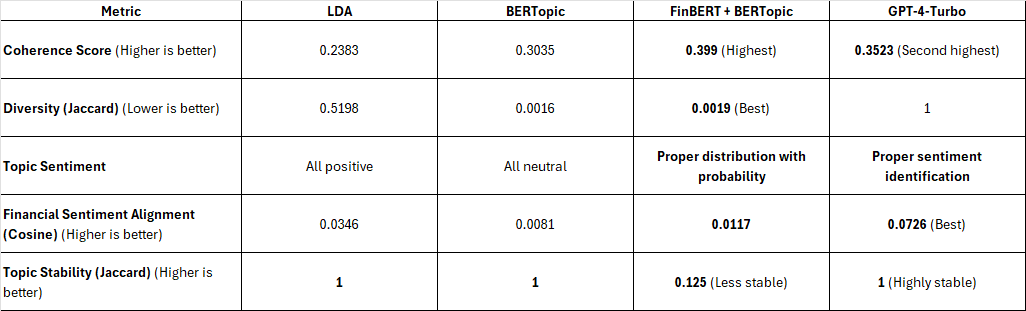

Final Recommendtation

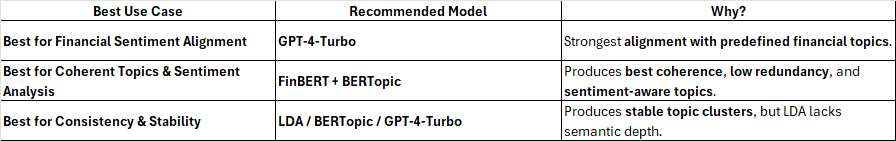